## Imports

In [1]:
from typing import Callable

import torch
import numpy as np
import plotly.io as pio
import plotly.express as px
from torch.optim import AdamW
from rich.progress import track
from pandas import DataFrame as DF
from torch.utils import data as torch_data
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader as DL
from torch.optim.lr_scheduler import ExponentialLR, LRScheduler, OneCycleLR

from models import UNet
from datasets import PreprocessedOpenFWI


pio.renderers.default = "jupyterlab+png"

## Datasets and data loaders

In [2]:
train_dataset = PreprocessedOpenFWI(train=True, norm_output=True, nb_files_to_load=100)
train_loader = torch_data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = PreprocessedOpenFWI(train=False, norm_output=True)
test_loader = torch_data.DataLoader(train_dataset, batch_size=128, shuffle=True)

Output()

Output()

Output()

Output()

## Training

### Definitions

In [ ]:
def fit(epochs:int,
        model: torch.nn.Module,
        scheduler: LRScheduler,
        optimizer: torch.optim.Optimizer,
        train_loader: DL,
        # evaluation_func,
    ) -> DF:
    scaler = GradScaler(device="cuda")
    metrics: list[dict] = []
    for epoch in range(epochs):
        total_epoch_loss = 0
        nb_samples = 0
        progress = track(train_loader, description=f"epoch {epoch}")
        step = 0
        for x, y in progress:
            # forward
            x = x.cuda()
            y = y.cuda()
            nb_samples += len(x)
            model.train()
            optimizer.zero_grad()
            with autocast(device_type="cuda"):
                y_pred = model(x)
            loss_value = (y_pred - y).abs().mean()
            
            if loss_value.item() is None:
                print("Warning: Got NaN loss, something went wring.")
                return DF.from_records(metrics) 
            # backward
            scaler.scale(loss_value).backward()
            # scaler.unscale_(optimizer)
            # optional grad clipping ?
            scaler.step(optimizer)
            scaler.update()
            if step:
                scheduler.step()
            # metrics
            # print(loss_value.item())
            total_epoch_loss += loss_value.item()
            metrics.append({
                "step": step,
                "epoch": epoch,
                "batch_train_loss": loss_value.item(),
                **optimizer.state_dict()["param_groups"][-1],
            })
            # progress.set_descriptionset_description(f"epoch: {epoch}, batch_loss: {loss_value.item():.4f}")
            step += 1

        metrics[-1]["train_epoch_loss"] = total_epoch_loss / len(train_loader)
        # metrics[-1].update(evaluation_func())
        print(metrics[-1]["train_epoch_loss"])
        
    return DF.from_records(metrics)

# def evaluate_model(model:torch.nn.Module, test_loader:DL) -> dict:

In [4]:
def mk_model() -> UNet:
    return UNet(
        in_channels=5,
        out_channels=1,
        start_features=32,
        depth=4
    ).cuda()

### Find lr

#### Run mock training

In [5]:
MOCK_TRAINING_EPOCHS = 3
STARTING_LR = 1e-5

mock_model = mk_model()
mock_optim = AdamW(mock_model.parameters(), lr=STARTING_LR)
mock_training_metrics = fit(
    epochs=MOCK_TRAINING_EPOCHS,
    model=mock_model,
    optimizer=mock_optim,
    scheduler=ExponentialLR(mock_optim, 1.01),
    train_loader=train_loader,
)
mock_training_metrics = (
    mock_training_metrics
    .query("batch_train_loss.notna()")
    .set_index("lr")
)

Output()

Output()

0.5092835245253164
tensor(False, device='cuda:0')


Output()

0.2132540545886076
tensor(False, device='cuda:0')


0.3124119239517405
tensor(False, device='cuda:0')


#### Visualize smoothed loss over learning rate

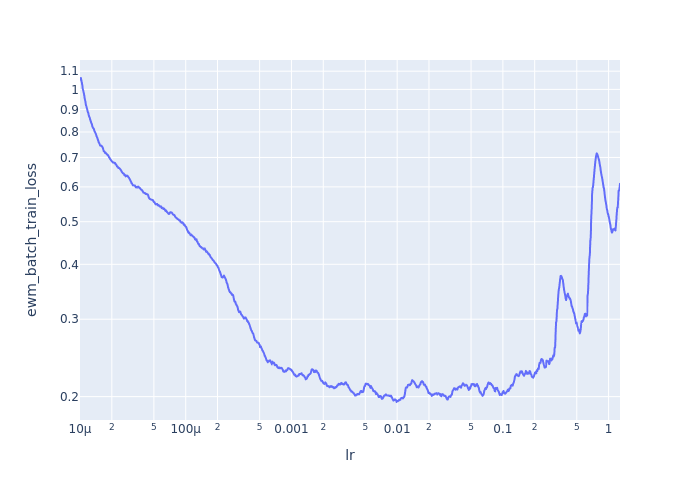

In [6]:
mock_training_metrics["ewm_batch_train_loss"] = (
    mock_training_metrics
    .ewm(com=15, ignore_na=False)
    ["batch_train_loss"]
    .mean()
)

px.line(
    mock_training_metrics,
    y="ewm_batch_train_loss",
    log_x=True,
    log_y=True
)

### Fit model

In [12]:
max_lr = mock_training_metrics["ewm_batch_train_loss"].idxmin() * 2
max_lr


TRAINING_EPOCHS = 6
STEPS_PER_EPOCH = len(mock_training_metrics.query("epoch == 0"))


model = mk_model()
optimizer = AdamW(model.parameters(), lr=max_lr)
scheduler = OneCycleLR(
    optimizer,
    max_lr,
    epochs=TRAINING_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH
)
training_metrics = fit(
    TRAINING_EPOCHS,
    model,
    scheduler,
    optimizer,
    train_loader
)

Output()

Output()

0.3036244066455696
tensor(False, device='cuda:0')


Output()

0.18202692345727847
tensor(False, device='cuda:0')


Output()

0.15324397992484176
tensor(False, device='cuda:0')


Output()

0.1308117830300633
tensor(False, device='cuda:0')


Output()

0.11063587816455696
tensor(False, device='cuda:0')


0.09496560398536392
tensor(False, device='cuda:0')


#### Visualize loss over training steps

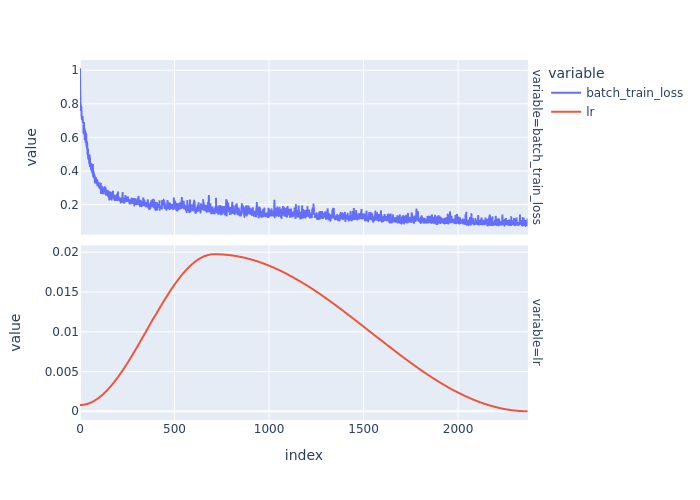

In [13]:
px.line(
    (
        training_metrics
        .reset_index()
        .melt(
            id_vars="index",
            value_vars=["batch_train_loss", "lr"],
        )
    ),
    x="index",
    y="value",
    color="variable",
    facet_row="variable",
).update_yaxes(matches=None)

## Visualize trained model's outputs

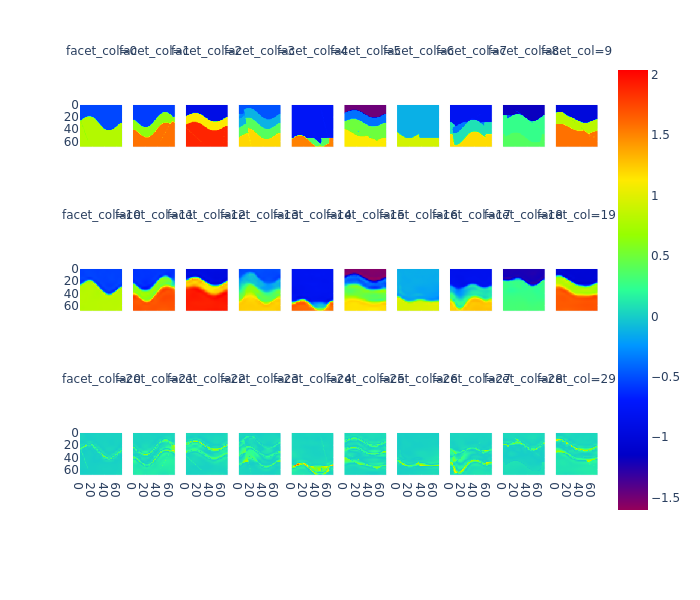

In [14]:
OFFSET = 50
IMGS_TO_SHOW = 10

x, y = next(iter(train_loader))


y_true_to_display = (
    y
    .cpu()
    .numpy()
    [OFFSET:OFFSET+IMGS_TO_SHOW, 0, ...]
)
with autocast("cuda"):
    y_pred = model(x.cuda())
y_pred_to_display = (
    y_pred
    .cpu()
    .detach()
    .numpy()
    [OFFSET:OFFSET+IMGS_TO_SHOW, 0, ...]
)

px.imshow(
    np.concatenate((
        y_true_to_display,
        y_pred_to_display,
        np.abs(y_pred_to_display - y_true_to_display), # Absolute loss
    )),
    facet_col=0,
    facet_col_wrap=IMGS_TO_SHOW,
    color_continuous_scale="Rainbow",
    height=600,
)